In [50]:
import os, glob

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.font_manager as fm
import matplotlib as mpl

plt.style.use('seaborn')
plt.rcParams["font.family"] = 'NanumGothic'
plt.rc('font', family='NanumGothic')
mpl.rcParams['axes.unicode_minus'] = False
%matplotlib inline

In [51]:
pathList = glob.glob('../raw/*')
for idx, p in enumerate(pathList[:4]):
    name = p.split(' ')[-1].split('.')[0]
    print(f'Load {name}')
    if idx < 3:
        globals()[name] = pd.read_csv(p, engine='python')
    else:
        globals()[name] = pd.read_excel(p)

Load mrc_info
Load samp_train
Load samp_cst_feat
Load variable_dtype


# PowerTransformer(급수 변환)

- 정규성을 가정하는 모델에 적합. 정규분포에 최대한 근사하게 모든 값에 급수를 취한다. 분산을 안정화하고, skewness를 최소화하는 효과
- MLE를 통해 가장 적절한 Power를 추정한다.
- Box-Cox와 Yeo-Johnson가 있다.
    - Box-Cox: 양수에서만 적용 가능
    - Yeo-Johnson: 0과 음수 또한 적용 가능 => Yeo-Johnson을 사용하는 게 효율적
    
[참고 : Power Transformer Document](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer)

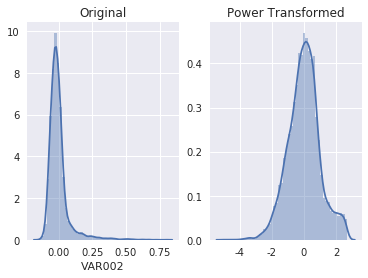

In [52]:
fig = plt.figure()

fig.add_subplot(1,2,1)
var_org = samp_cst_feat['VAR002']
sns.distplot(var_org)
plt.title('Original')

fig.add_subplot(1,2,2)
from sklearn.preprocessing import PowerTransformer
pt = PowerTransformer(method = 'yeo-johnson', standardize=True)
var_pt = pt.fit_transform(var_org.values.reshape(-1,1))
sns.distplot(var_pt)
plt.title('Power Transformed')

plt.show()

# QuantileTransformer(분위수 변환)
- 이상치가 심각한 분포에 적합. N분위수로 변환한다.    
[참고 : Quantile Transformer Document](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html)

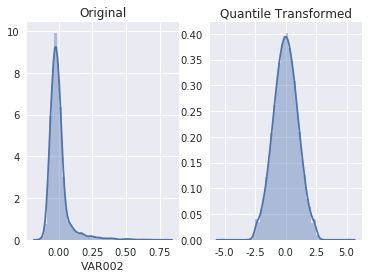

In [55]:
fig = plt.figure()

fig.add_subplot(1,2,1)
var_org = samp_cst_feat['VAR002']
sns.distplot(var_org)
plt.title('Original')

fig.add_subplot(1,2,2)
from sklearn.preprocessing import QuantileTransformer
qt = QuantileTransformer(
    n_quantiles = 100,
    output_distribution='normal',
    random_state=0
    )
var_qt = qt.fit_transform(var_org.values.reshape(-1,1))
sns.distplot(var_qt)
plt.title('Quantile Transformed')
plt.show()

# KBinsDiscretizer(K-막대 분리)
- K-방역 아님 주의
- K개의 구간으로 나누어 범주형 자료로 인코딩(지형이가 얘기했던)
- 방법은 uniform, quantile, kmeans 세 가지
    - uniform: All bins in each feature have identical widths.
    - quantile: All bins in each feature have the same number of points.
    - kmeans: Values in each bin have the same nearest center of a 1D k-means cluster.  
[참고 : KBinsDiscretizer Document](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.KBinsDiscretizer.html#sklearn.preprocessing.KBinsDiscretizer)

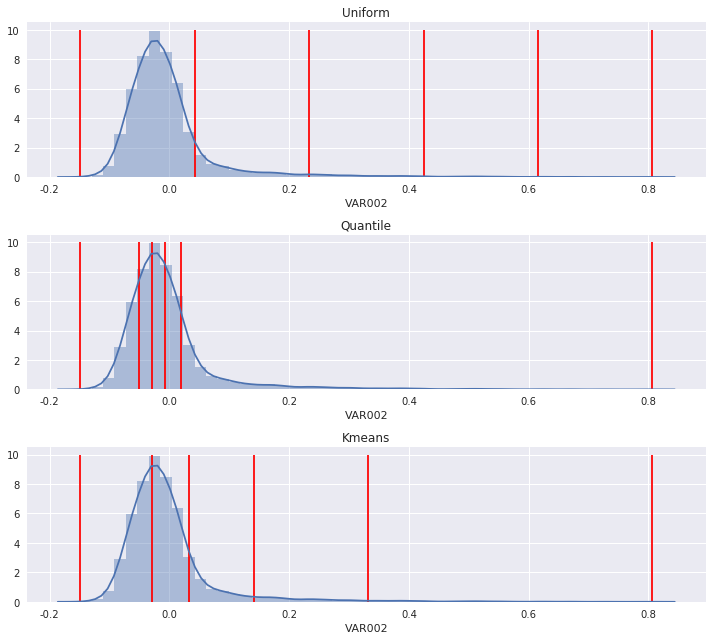

In [91]:
from sklearn.preprocessing import KBinsDiscretizer

fig = plt.figure(figsize=(10,9))

fig.add_subplot(3,1,1)
var_org = samp_cst_feat['VAR002']
sns.distplot(var_org)
plt.title('Uniform')

est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='uniform')
var_est = est.fit(var_org.values.reshape(-1,1))

for i in est.bin_edges_:
    plt.vlines(i, ymin=0, ymax=10, color='red')

fig.add_subplot(3,1,2)
var_org = samp_cst_feat['VAR002']
sns.distplot(var_org)
plt.title('Quantile')

est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='quantile')
var_est = est.fit_transform(var_org.values.reshape(-1,1))

for i in est.bin_edges_:
    plt.vlines(i, ymin=0, ymax=10, color='red')
    
    
fig.add_subplot(3,1,3)
var_org = samp_cst_feat['VAR002']
sns.distplot(var_org)
plt.title('Kmeans')

est = KBinsDiscretizer(n_bins=5, encode='ordinal', strategy='kmeans')
var_est = est.fit_transform(var_org.values.reshape(-1,1))

for i in est.bin_edges_:
    plt.vlines(i, ymin=0, ymax=10, color='red')

plt.tight_layout()
plt.show()

# PolynomialFeatures(다항 피처)
- 독립적인 변수들을 제곱하고 곱하여 교호 작용을 추가하는 방식
- 제곱하는 건 PowerTransform에서도 가능하니 교호작용만 추가하는 게 좋을 듯
[참고 : PolynomialFeatures Document](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html#sklearn.preprocessing.PolynomialFeatures)

In [109]:
var_twin = samp_cst_feat[['VAR002','VAR003']]
from sklearn.preprocessing import PolynomialFeatures

poly = PolynomialFeatures(2, include_bias=False)
var_poly = poly.fit_transform(var_twin)
pd.DataFrame(var_poly).head()

,0,1,2,3,4
0,-0.06610,0.5280,0.004369,-0.034901,0.278784
1,-0.09537,0.1347,0.009095,-0.012846,0.018144
2,-0.01048,0.8360,0.000110,-0.008761,0.698896
3,0.05194,0.7505,0.002698,0.038981,0.563250
4,-0.08536,0.3767,0.007286,-0.032155,0.141903


In [105]:
poly = PolynomialFeatures(2, interaction_only=True, include_bias=False)
var_poly = poly.fit_transform(var_twin)
pd.DataFrame(var_poly).head()

,0,1,2
0,-0.06610,0.5280,-0.034901
1,-0.09537,0.1347,-0.012846
2,-0.01048,0.8360,-0.008761
3,0.05194,0.7505,0.038981
4,-0.08536,0.3767,-0.032155
